In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, create_lags, apply_moving_average_for_roc, split_data_frame, create_sequences, simplify_df, trigonometric_date_encoding
import tensorflow as tf
import time

### Preprocessing

In [2]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               38656 non-null  int64         
 1   time                    38656 non-null  datetime64[ns]
 2   open                    38656 non-null  float64       
 3   close                   38656 non-null  float64       
 4   high                    38656 non-null  float64       
 5   low                     38656 non-null  float64       
 6   volume_24h              38656 non-null  float64       
 7   circulating_supply      38656 non-null  float64       
 8   day                     38656 non-null  int32         
 9   month                   38656 non-null  int32         
 10  year                    38656 non-null  int32         
 11  Month_Category_Bearish  38656 non-null  float64       
 12  Month_Category_Bullish  38656 non-null  float6

In [4]:
df.head(10)

,timestamp,time,open,close,high,low,volume_24h,circulating_supply,day,month,year,Month_Category_Bearish,Month_Category_Bullish,Month_Category_Normal,ROC_0,ROC_1,ROC_2
0,1567036800,2019-08-29,9699.30,9492.81,9709.59,9344.69,2.119802e+10,18461987.0,29,8,2019,0.0,1.0,0.0,0,0,1
1,1567123200,2019-08-30,9453.74,9587.25,9699.85,9368.27,2.119802e+10,18461987.0,30,8,2019,0.0,1.0,0.0,0,0,1
2,1567209600,2019-08-31,9603.96,9624.54,9714.11,9512.03,2.119802e+10,18461987.0,31,8,2019,0.0,1.0,0.0,0,0,1
3,1567296000,2019-09-01,9646.58,9768.36,9823.53,9578.66,2.119802e+10,18461987.0,1,9,2019,0.0,0.0,1.0,0,0,1
4,1567382400,2019-09-02,9783.44,10387.50,10459.00,9764.76,2.119802e+10,18461987.0,2,9,2019,0.0,0.0,1.0,0,0,1
5,1567468800,2019-09-03,10406.81,10625.10,10773.27,10296.30,2.119802e+10,18461987.0,3,9,2019,0.0,0.0,1.0,0,0,1
6,1567555200,2019-09-04,10589.31,10585.20,10827.14,10392.88,2.119802e+10,18461987.0,4,9,2019,0.0,0.0,1.0,0,0,1
7,1567641600,2019-09-05,10534.67,10556.16,10659.60,10475.88,2.119802e+10,18461987.0,5,9,2019,0.0,0.0,1.0,0,0,1
8,1567728000,2019-09-06,10564.49,10309.91,10938.39,10228.17,2.119802e+10,18461987.0,6,9,2019,0.0,0.0,1.0,0,0,1
9,1567814400,2019-09-07,10340.02,10491.96,10574.99,10331.88,2.119802e+10,18461987.0,7,9,2019,0.0,0.0,1.0,0,0,1


In [5]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [6]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [7]:
def apply_functions(train, test, val):
    
    excluded_columns = ["Month_Category_Bearish", "Month_Category_Bullish", "Month_Category_Normal"]
    features_to_standardize = [column for column in train.columns if column not in excluded_columns]

    # Calculate the mean and standard deviation only for the required columns
    train_mean = train[features_to_standardize].mean()
    train_std = train[features_to_standardize].std()

    # Standardize only the required columns in the train, validation, and test sets
    train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
    val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
    test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

    X_train, y_train = create_sequences(train, 5)
    X_val, y_val = create_sequences(val, 5)
    X_test, y_test = create_sequences(test, 5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76071/1656841905.py:11: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76071/1656841905.py:12: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76071/1656841905.py:13: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std


In [8]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27053, 5, 19)
y_train shape: (27053,)
X_val shape: (7725, 5, 19)
y_val shape: (7725,)
X_test shape: (3860, 5, 19)
y_test shape: (3860,)


In [9]:
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

In [10]:
def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 19, 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)

In [11]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [12]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 19)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 5, 19)                38        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 5, 19)                40467     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [13]:
def fit_transformer(transformer: tf.keras.Model):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
    start = time.time()
    hist = transformer.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, verbose=1, callbacks=callbacks).history
    print(time.time() - start)
    return hist

In [14]:
hist = fit_transformer(transformer)

Epoch 1/100
423/423 [==============================] - 11s 23ms/step - loss: 0.0223 - mae: 0.0885 - mape: 37.8445 - val_loss: 0.0583 - val_mae: 0.2305 - val_mape: 800.5831 - lr: 0.0010
Epoch 2/100
423/423 [==============================] - 11s 26ms/step - loss: 0.0047 - mae: 0.0515 - mape: 10.1548 - val_loss: 0.0134 - val_mae: 0.1078 - val_mape: 368.6181 - lr: 0.0010
Epoch 3/100
423/423 [==============================] - 11s 27ms/step - loss: 0.0034 - mae: 0.0434 - mape: 12.8509 - val_loss: 0.0063 - val_mae: 0.0725 - val_mape: 229.7358 - lr: 0.0010
Epoch 4/100
423/423 [==============================] - 12s 28ms/step - loss: 0.0027 - mae: 0.0390 - mape: 8.9995 - val_loss: 0.0081 - val_mae: 0.0833 - val_mape: 275.8234 - lr: 0.0010
Epoch 5/100
423/423 [==============================] - 12s 28ms/step - loss: 0.0024 - mae: 0.0367 - mape: 11.7838 - val_loss: 0.0035 - val_mae: 0.0533 - val_mape: 189.5420 - lr: 0.0010
Epoch 6/100
423/423 [==============================] - 11s 27ms/step - loss:

In [15]:
def evaluate(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 4s 4ms/step


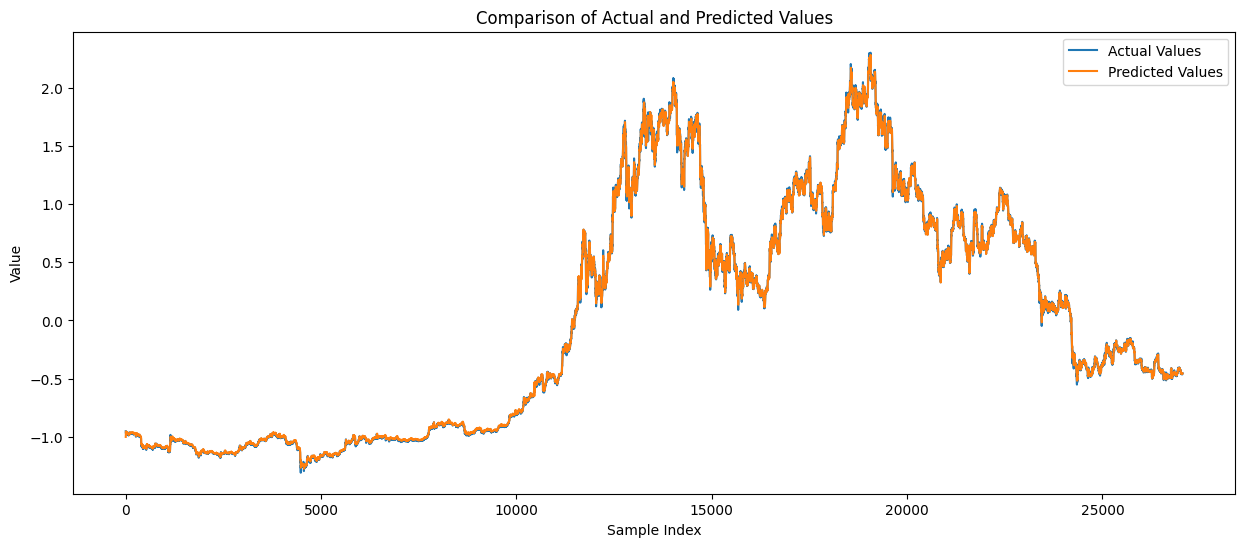

In [16]:
evaluate(transformer, X_train, y_train)

242/242 [==============================] - 1s 5ms/step


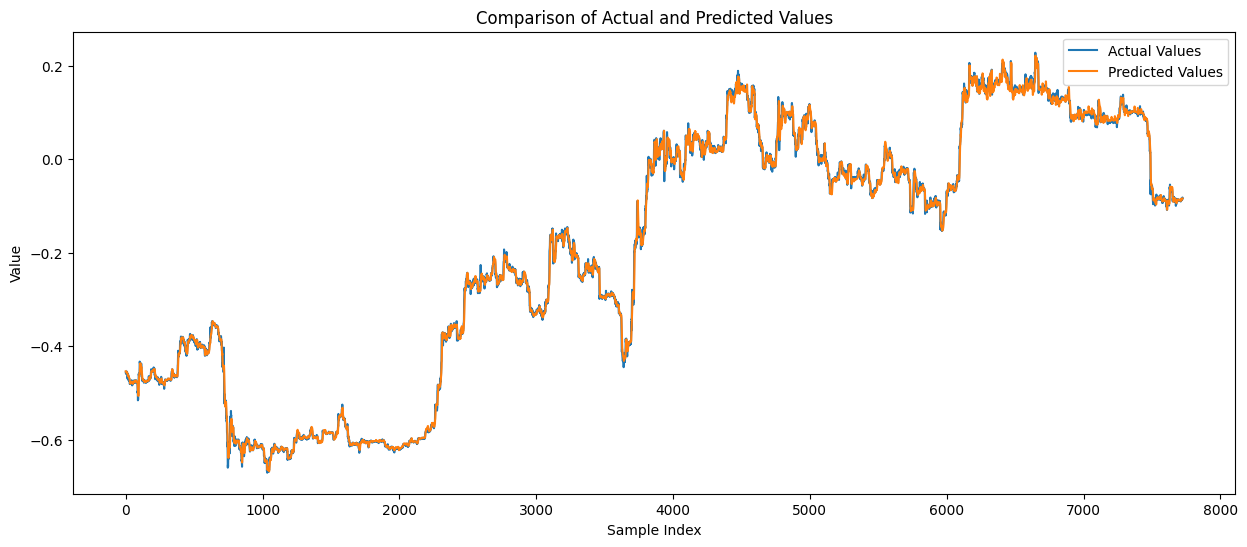

In [17]:
evaluate(transformer, X_val, y_val)

121/121 [==============================] - 0s 4ms/step


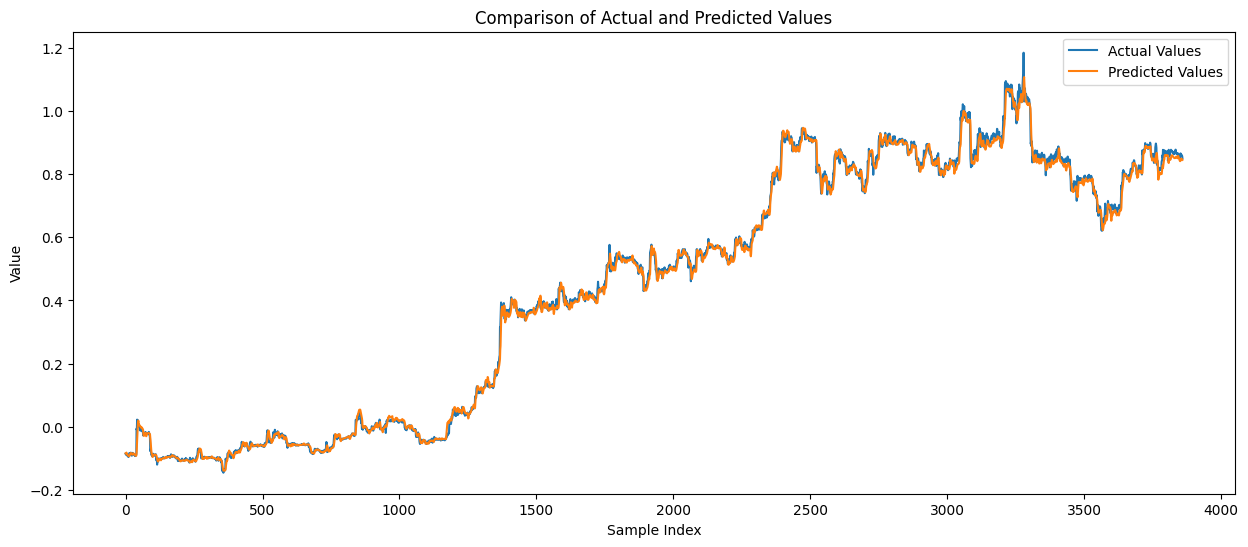

In [18]:
evaluate(transformer, X_test, y_test)

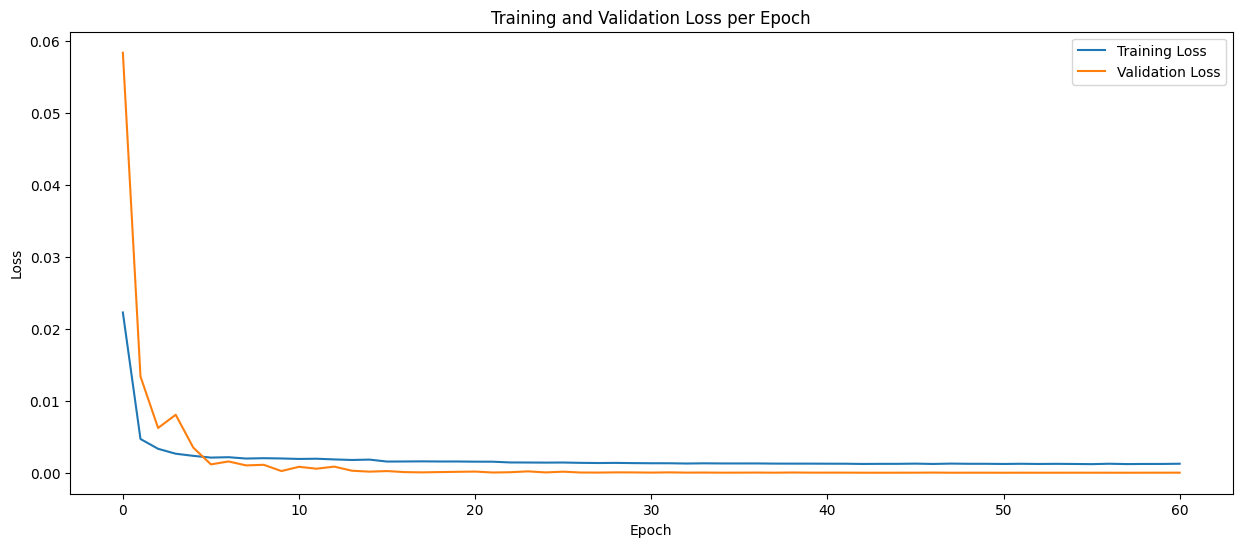

In [19]:
import matplotlib.pyplot as plt

# Extracting loss data from the history object
train_loss = hist['loss']
val_loss = hist['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()